<a href="https://colab.research.google.com/github/seyed-mohammadreza-mousavi/ml-playground-starter/blob/main/03-support-vector-machine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Support Vector Machines (SVM): A Comprehensive, Hands-on Guide

This notebook is a practical deep dive into Support Vector Machines for **classification** and **regression** using scikit-learn.

You’ll get:
- Intuition and math (soft-margin SVM, kernels, regularization)
- Clean, reusable code (pipelines, scaling, model selection)
- Visualizations (decision boundaries, margin, learning curves)
- Real datasets (Iris, Breast Cancer) + synthetic demos
- Advanced topics (class imbalance, probability calibration, multiclass OvR vs OvO)
- SVR for regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC, SVR
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, RocCurveDisplay,
    PrecisionRecallDisplay, roc_auc_score, ConfusionMatrixDisplay,
    mean_squared_error, r2_score
)
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

## 1) Intuition & Math (Soft-Margin + Kernels)

**Goal (binary classification):** find a hyperplane with maximum margin that separates two classes.

For a linear SVM, the decision function is

$$
f(\mathbf{x}) = \mathbf{w}^{\top}\mathbf{x} + b
$$

**Hard-margin (linearly separable):**

$$
\min_{\mathbf{w},\, b}\ \frac{1}{2}\,\|\mathbf{w}\|^{2}
\quad \text{s.t.} \quad
y_i\big(\mathbf{w}^{\top}\mathbf{x}_i + b\big) \ge 1,\ \forall i
$$

**Soft-margin (allows errors):**

$$
\min_{\mathbf{w},\, b,\, \xi}\ \frac{1}{2}\,\|\mathbf{w}\|^{2} + C \sum_{i=1}^{n} \xi_i
\quad \text{s.t.} \quad
y_i\big(\mathbf{w}^{\top}\mathbf{x}_i + b\big) \ge 1 - \xi_i,\ \ \xi_i \ge 0
$$

**Kernel trick (for nonlinearity):**

- Linear: \( K(\mathbf{x},\mathbf{z})=\mathbf{x}^{\top}\mathbf{z} \)
- RBF: \( K(\mathbf{x},\mathbf{z})=\exp\!\big(-\gamma\|\mathbf{x}-\mathbf{z}\|^2\big) \)
- Polynomial: \( K(\mathbf{x},\mathbf{z})=(\gamma\,\mathbf{x}^{\top}\mathbf{z}+r)^d \)

**Key hyperparameters:** `C`, `gamma` (RBF/poly), `degree` & `coef0` (poly).

In [2]:
from sklearn.datasets import make_moons, make_circles, make_classification

def plot_decision_function_2d(model, X, y, title='Decision boundary'):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400),
                         np.linspace(y_min, y_max, 400))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plt.figure()
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y)
    plt.title(title)
    plt.xlabel('x1'); plt.ylabel('x2')
    plt.show()

def make_and_split(dataset='moons', noise=0.3, test_size=0.3):
    if dataset == 'moons':
        X, y = make_moons(n_samples=600, noise=noise, random_state=42)
    elif dataset == 'circles':
        X, y = make_circles(n_samples=600, noise=noise, factor=0.5, random_state=42)
    else:
        X, y = make_classification(n_samples=800, n_features=2, n_redundant=0,
                                   n_informative=2, n_clusters_per_class=1,
                                   flip_y=0.05, class_sep=1.5, random_state=42)
    return train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)

### 2.1) Linear SVM on nearly linearly separable data

Accuracy (LinearSVC): 0.92


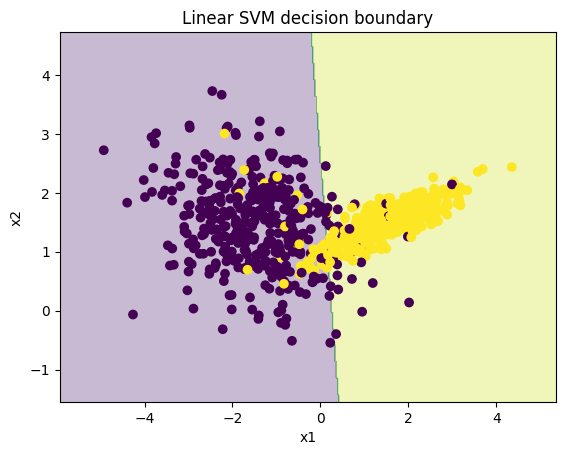

In [3]:
X_train, X_test, y_train, y_test = make_and_split('linear', noise=0.1, test_size=0.25)

lin_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LinearSVC(C=1.0))
])
lin_clf.fit(X_train, y_train)
y_pred = lin_clf.predict(X_test)
print('Accuracy (LinearSVC):', accuracy_score(y_test, y_pred))

plot_decision_function_2d(lin_clf, np.vstack([X_train, X_test]), np.hstack([y_train, y_test]),
                          title='Linear SVM decision boundary')

### 2.2) RBF Kernel SVM on non-linear data (two moons)

Accuracy (RBF SVC): 0.9266666666666666


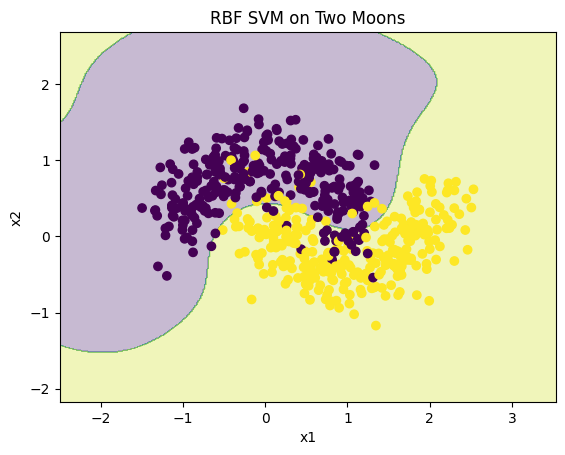

In [4]:
X_train, X_test, y_train, y_test = make_and_split('moons', noise=0.25, test_size=0.25)

rbf_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC(kernel='rbf', C=1.0, gamma='scale'))
])
rbf_clf.fit(X_train, y_train)
y_pred = rbf_clf.predict(X_test)
print('Accuracy (RBF SVC):', accuracy_score(y_test, y_pred))

plot_decision_function_2d(rbf_clf, np.vstack([X_train, X_test]), np.hstack([y_train, y_test]),
                          title='RBF SVM on Two Moons')

### 2.3) Polynomial Kernel SVM on concentric circles

Accuracy (Poly SVC): 0.9666666666666667


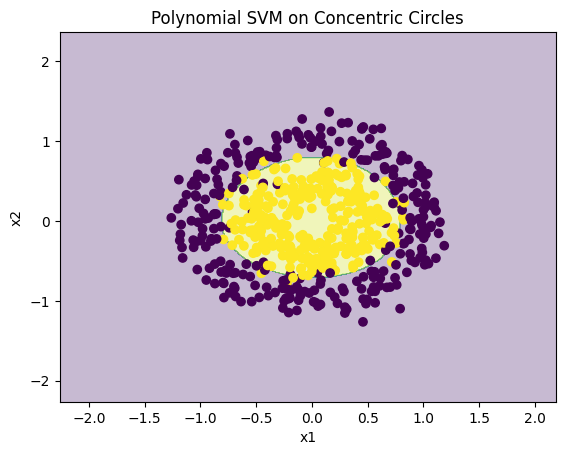

In [5]:
X_train, X_test, y_train, y_test = make_and_split('circles', noise=0.15, test_size=0.25)

poly_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC(kernel='poly', degree=3, coef0=1.0, C=1.0, gamma='scale'))
])
poly_clf.fit(X_train, y_train)
y_pred = poly_clf.predict(X_test)
print('Accuracy (Poly SVC):', accuracy_score(y_test, y_pred))

plot_decision_function_2d(poly_clf, np.vstack([X_train, X_test]), np.hstack([y_train, y_test]),
                          title='Polynomial SVM on Concentric Circles')

## 3) Model Selection with GridSearchCV (Breast Cancer dataset)

We’ll tune `C` and `gamma` for an RBF SVC using ROC-AUC.

Best params: {'clf__C': 10, 'clf__gamma': 0.01}
Best CV ROC-AUC: 0.9970911949685535
Test Accuracy: 0.9790209790209791
Test ROC-AUC: 0.9987421383647799

Classification report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97        53
           1       0.99      0.98      0.98        90

    accuracy                           0.98       143
   macro avg       0.98      0.98      0.98       143
weighted avg       0.98      0.98      0.98       143



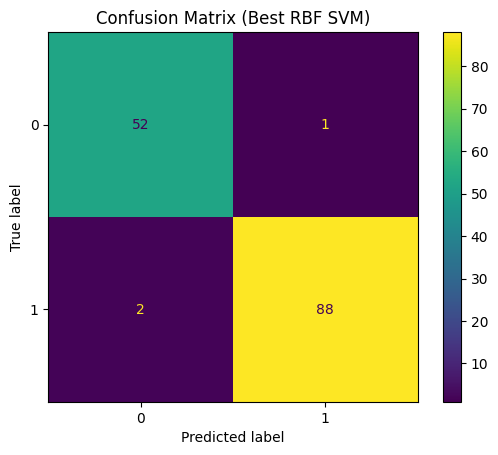

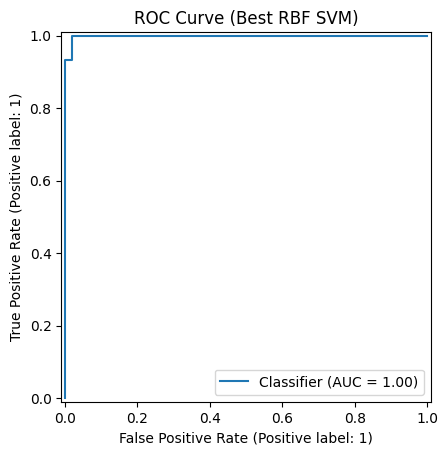

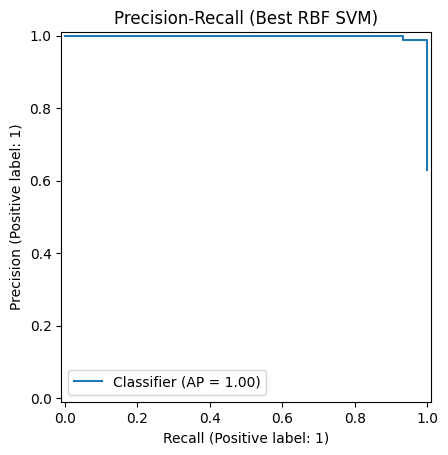

In [6]:
data = datasets.load_breast_cancer()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

pipe = Pipeline([('scaler', StandardScaler()), ('clf', SVC(kernel='rbf', probability=True))])

param_grid = {
    'clf__C': [0.1, 1, 10, 100],
    'clf__gamma': ['scale', 0.1, 0.01, 0.001]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(pipe, param_grid, scoring='roc_auc', cv=cv, n_jobs=-1, refit=True)
grid.fit(X_train, y_train)

print('Best params:', grid.best_params_)
print('Best CV ROC-AUC:', grid.best_score_)

best_model = grid.best_estimator_
y_proba = best_model.predict_proba(X_test)[:, 1]
y_pred = best_model.predict(X_test)

print('Test Accuracy:', accuracy_score(y_test, y_pred))
print('Test ROC-AUC:', roc_auc_score(y_test, y_proba))
print("\nClassification report:\n", classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title('Confusion Matrix (Best RBF SVM)')
plt.show()

RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title('ROC Curve (Best RBF SVM)')
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, y_proba)
plt.title('Precision-Recall (Best RBF SVM)')
plt.show()

## 4) Multiclass SVM: OvR vs OvO (Iris)

- `SVC` uses **One-vs-One (OvO)** internally.
- `LinearSVC` is typically used with **One-vs-Rest (OvR)**.

In [7]:
iris = datasets.load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

ovo = Pipeline([('scaler', StandardScaler()), ('clf', SVC(kernel='rbf'))])
ovr = Pipeline([('scaler', StandardScaler()), ('clf', LinearSVC(C=1.0))])

for name, clf in [('OvO (SVC RBF)', ovo), ('OvR (LinearSVC)', ovr)]:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f'{name} accuracy:', accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=iris.target_names))

OvO (SVC RBF) accuracy: 0.9473684210526315
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        12
  versicolor       0.92      0.92      0.92        13
   virginica       0.92      0.92      0.92        13

    accuracy                           0.95        38
   macro avg       0.95      0.95      0.95        38
weighted avg       0.95      0.95      0.95        38

OvR (LinearSVC) accuracy: 0.868421052631579
              precision    recall  f1-score   support

      setosa       1.00      0.92      0.96        12
  versicolor       0.83      0.77      0.80        13
   virginica       0.80      0.92      0.86        13

    accuracy                           0.87        38
   macro avg       0.88      0.87      0.87        38
weighted avg       0.87      0.87      0.87        38



## 5) Handling Class Imbalance

Compare baseline SVC vs `class_weight='balanced'` using ROC-AUC on an imbalanced synthetic dataset.

In [8]:
X, y = datasets.make_classification(n_samples=3000, n_features=12, n_informative=6,
                                    n_redundant=2, weights=[0.9, 0.1], random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

# Baseline
base = Pipeline([('scaler', StandardScaler()), ('clf', SVC(kernel='rbf', probability=True))])
base.fit(X_train, y_train)
y_proba_base = base.predict_proba(X_test)[:, 1]
print('Baseline ROC-AUC:', roc_auc_score(y_test, y_proba_base))

# Balanced
balanced = Pipeline([('scaler', StandardScaler()),
                     ('clf', SVC(kernel='rbf', probability=True, class_weight='balanced'))])
balanced.fit(X_train, y_train)
y_proba_bal = balanced.predict_proba(X_test)[:, 1]
print('Balanced ROC-AUC:', roc_auc_score(y_test, y_proba_bal))

Baseline ROC-AUC: 0.9194711538461539
Balanced ROC-AUC: 0.9224664224664225


## 6) Probability Calibration

Setting `probability=True` in `SVC` applies internal Platt scaling (adds cost).  
We visualize the ROC and PR curves on Breast Cancer.

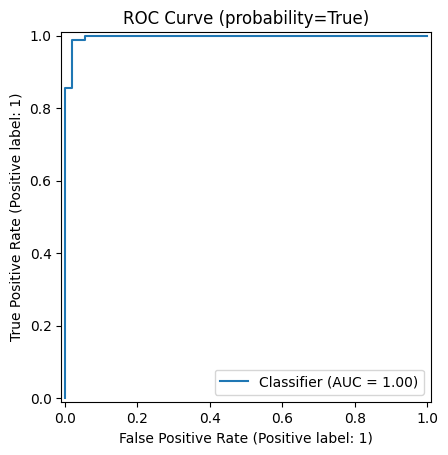

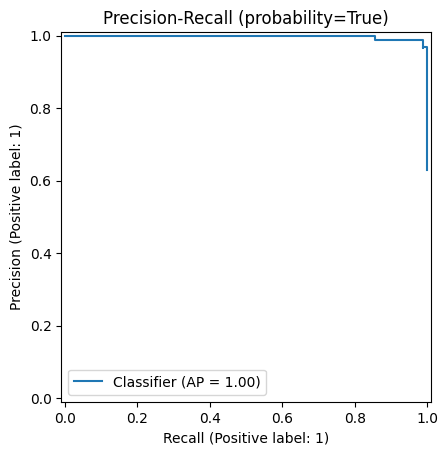

In [9]:
# Re-train a quick calibrated model if needed
data = datasets.load_breast_cancer()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

cal_model = Pipeline([('scaler', StandardScaler()), ('clf', SVC(kernel='rbf', probability=True))])
cal_model.fit(X_train, y_train)

y_proba = cal_model.predict_proba(X_test)[:, 1]

RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title('ROC Curve (probability=True)')
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, y_proba)
plt.title('Precision-Recall (probability=True)')
plt.show()

## 7) Learning Curves

Check bias/variance behavior and data sufficiency with an RBF SVC on Breast Cancer.

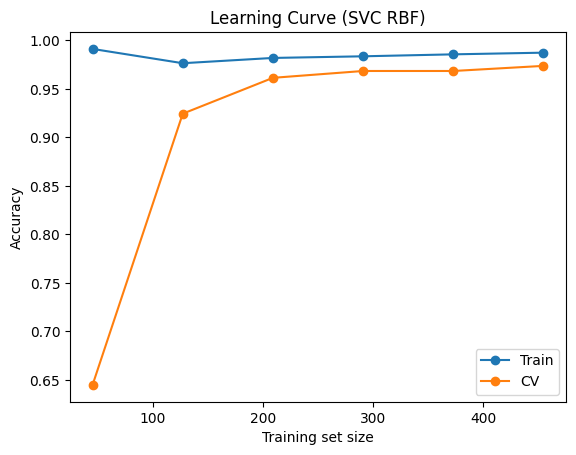

In [10]:
data = datasets.load_breast_cancer()
X, y = data.data, data.target

pipe = Pipeline([('scaler', StandardScaler()), ('clf', SVC(kernel='rbf'))])

train_sizes, train_scores, valid_scores = learning_curve(
    pipe, X, y, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 6), random_state=42
)

train_mean = train_scores.mean(axis=1)
valid_mean = valid_scores.mean(axis=1)

plt.figure()
plt.plot(train_sizes, train_mean, marker='o', label='Train')
plt.plot(train_sizes, valid_mean, marker='o', label='CV')
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.title('Learning Curve (SVC RBF)')
plt.legend()
plt.show()

## 8) Why Scaling Matters

SVMs are sensitive to feature scales. Compare accuracy with and without scaling.

In [11]:
X, y = datasets.make_classification(n_samples=1200, n_features=20, n_informative=10, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Without scaling
clf_noscale = SVC(kernel='rbf')
clf_noscale.fit(X_train, y_train)
print('No scaling accuracy:', accuracy_score(y_test, clf_noscale.predict(X_test)))

# With scaling
pipe_scale = Pipeline([('scaler', StandardScaler()), ('clf', SVC(kernel='rbf'))])
pipe_scale.fit(X_train, y_train)
print('With scaling accuracy:', accuracy_score(y_test, pipe_scale.predict(X_test)))

No scaling accuracy: 0.9233333333333333
With scaling accuracy: 0.9066666666666666


## 9) SVM for Regression (SVR)

Train an RBF SVR and report RMSE and \(R^2\). Then plot predicted vs actual.

SVR RMSE: 84.19158261851138
SVR R^2: 0.7747171085478222


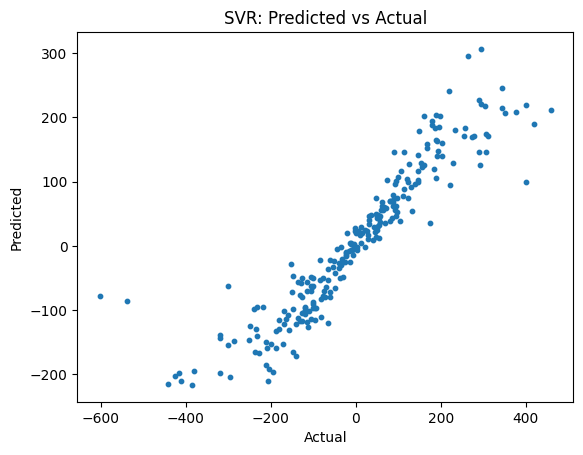

In [14]:
from sklearn.datasets import make_regression

X, y = make_regression(n_samples=1000, n_features=8, noise=15.0, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

svr_pipe = Pipeline([('scaler', StandardScaler()), ('svr', SVR(kernel='rbf', C=10.0, epsilon=0.1))])
svr_pipe.fit(X_train, y_train)
y_pred = svr_pipe.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('SVR RMSE:', rmse)
print('SVR R^2:', r2_score(y_test, y_pred))

plt.figure()
plt.scatter(y_test, y_pred, s=10)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('SVR: Predicted vs Actual')
plt.show()

## 10) Inspecting Support Vectors & (approx.) margins (2D linear)

We visualize the decision boundary and where support vectors lie.

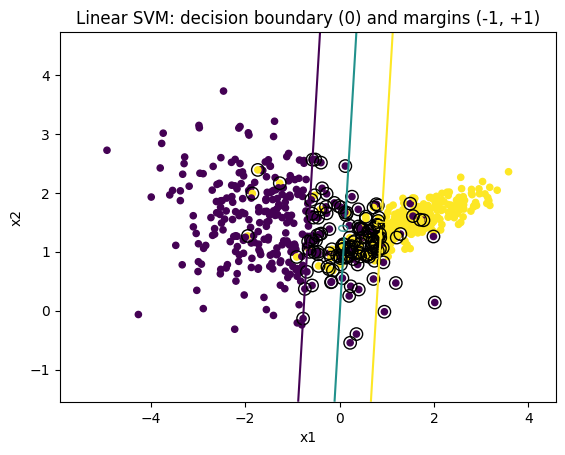

In [15]:
# Reuse 2D linear-ish dataset
X_train, X_test, y_train, y_test = make_and_split('linear', noise=0.1, test_size=0.25)

svc_linear = Pipeline([('scaler', StandardScaler()), ('clf', SVC(kernel='linear', C=1.0))])
svc_linear.fit(X_train, y_train)

# decision function grid
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400), np.linspace(y_min, y_max, 400))
Z = svc_linear.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure()
CS = plt.contour(xx, yy, Z, levels=[-1, 0, 1])
plt.clabel(CS, inline=True)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=20)

# mark support vectors (indices refer to training set)
clf = svc_linear.named_steps['clf']
sv_idx = clf.support_
plt.scatter(X_train[sv_idx, 0], X_train[sv_idx, 1], edgecolors='k', facecolors='none', s=80)

plt.title('Linear SVM: decision boundary (0) and margins (-1, +1)')
plt.xlabel('x1'); plt.ylabel('x2')
plt.show()

## 11) Practical Tips

- **Always scale** features for SVMs (especially RBF/poly).
- Start with **RBF** for non-linear data; tune `C` and `gamma`.
- For high-dimensional sparse data (e.g., text), try **LinearSVC**.
- Use **`class_weight='balanced'`** or custom weights for imbalance.
- **`probability=True`** adds calibration but increases training time.
- Use **Pipelines** to avoid data leakage (scaling inside CV).
- Check **learning curves** before collecting more data.
- For multiclass, try both **OvO (SVC)** and **OvR (LinearSVC)**.
- For **SVR**, tune `C`, `epsilon`, and `gamma` similarly to classification.

## 12) Exercises

1. On the Breast Cancer dataset, try a **Polynomial SVM** and tune `degree`, `C`, and `gamma`. Compare ROC-AUC with RBF.
2. On the Iris dataset, compare **LinearSVC** vs **RBF SVC** in accuracy and runtime.
3. On an imbalanced dataset, compare models using **PR-AUC** as the primary metric.
4. For SVR, tune `epsilon` and `C`—plot how RMSE changes with different values.
5. Add `PolynomialFeatures` before a LinearSVC and measure gains/losses.